# Imports necesarios

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

#Cargamos el DataSet


In [2]:
ruta_csv = "/content/SSNMX_catalogo_19800301_20220307.csv"

In [3]:
df_terre = pd.read_csv(ruta_csv, skiprows=4, skip_blank_lines=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_terre.head(4)

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1980-03-01,04:39:55,no calculable,16.64,-94.71,129.0,"22 km al NORESTE de UNION HIDALGO, OAX",1980-03-01,10:39:55,revisado
1,1980-03-01,12:56:11,no calculable,17.18,-102.34,33.0,"87 km al SUR de CD LAZARO CARDENAS, MICH",1980-03-01,18:56:11,revisado
2,1980-03-01,16:10:53,no calculable,15.41,-93.92,33.0,"77 km al SUR de TONALA, CHIS",1980-03-01,22:10:53,revisado
3,1980-03-02,03:23:30,4.8,14.84,-96.86,33.0,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",1980-03-02,09:23:30,revisado


# Manejo de Fechas

In [5]:
df_sample = df_terre['Fecha UTC'] + ' ' +df_terre['Hora UTC']


df_sample = df_sample.apply( lambda x: pd.to_datetime(x, errors='coerce') )


df_terre['Fecha y Hora UTC'] = df_sample

In [6]:
df_terre.drop(
    columns = ['Fecha', 'Hora', 'Fecha UTC', 'Hora UTC'],
    inplace= True
)
df_terre.dropna(inplace=True)

In [7]:
df_terre['Año'] = df_terre['Fecha y Hora UTC'].apply(lambda x: x.year)

In [8]:
df_terre.head(5)

,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Estatus,Fecha y Hora UTC,Año
0,no calculable,16.64,-94.71,129.0,"22 km al NORESTE de UNION HIDALGO, OAX",revisado,1980-03-01 10:39:55,1980
1,no calculable,17.18,-102.34,33.0,"87 km al SUR de CD LAZARO CARDENAS, MICH",revisado,1980-03-01 18:56:11,1980
2,no calculable,15.41,-93.92,33.0,"77 km al SUR de TONALA, CHIS",revisado,1980-03-01 22:10:53,1980
3,4.8,14.84,-96.86,33.0,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",revisado,1980-03-02 09:23:30,1980
4,no calculable,15.30,-97.25,33.0,"65 km al SUROESTE de PUERTO ESCONDIDO, OAX",revisado,1980-03-02 09:29:14,1980


# Definicion de Funciones

In [9]:
def acronimos(estado):
  patron = '(.+,)(\ [A-Z]{2,4})'
  acro = re.search(pattern=patron, string=estado)
  if acro is not None:
    return acro.group(2)
  else:
    return None


def municipio(referencia):
  patron= r"(\w+\skm\sal\s\w+\sde\s)(.+)(,\s.+)"

  municipio = re.search(pattern=patron, string=referencia)
  
  if municipio is not None:
    return municipio.group(2)
  else:
    return None



##  FUNCIONES DE VISUALIZACION CON SEABORN
def displot_sbn_df(
    df: pd.DataFrame, 
    x: str, 
    hue: Optional[str] = None, 
    y_name: Optional[str] = None
):
  plt.figure(figsize=(14,10))

  dis = sns.displot(
      df,
      x = x,
      hue= hue,
      kde = True,
      height=10, 
      aspect=.9,
  )
  dis.set_axis_labels(x_var=x, y_var=y_name)


def countplot_sbn_df(df: pd.DataFrame, y: str):
  plt.figure(figsize=(14,10))

  sns.countplot(
      data= df,
      y= y,
      order= df[y].value_counts().index
  )


def boxplot_swarmplot_sbn_df(df: pd.DataFrame, x: str, y: str):
  plt.figure(figsize=(16,12))

  sns.boxplot(
      data= df_Estado,
      x= x,
      y= y,
  )

  sns.swarmplot(
      data= df_Estado,
      x= x,
      y= y,
      color= '.25'
  )



### FUNCION PARA CREAR UN DF PARA UN ESTADO EN ESPECIFICO
def crear_df_estado(estado: str):
  estado = estado.upper()
  return df_bak[df_bak['Estado'].isin([' '+estado])]

# Agregamos el Año, Estado y Municipio

In [10]:
df_terre.dtypes

Magnitud                              object
Latitud                              float64
Longitud                             float64
Profundidad                           object
Referencia de localizacion            object
Estatus                               object
Fecha y Hora UTC              datetime64[ns]
Año                                    int64
dtype: object

In [11]:
df_terre['Estado'] = df_terre['Referencia de localizacion'].apply(
    lambda x: acronimos(str(x))
)

df_terre['Municipio'] = df_terre['Referencia de localizacion'].apply(
    lambda x: municipio(str(x))
)

In [12]:
df_terre['Estado'].value_counts().head()

 OAX     98856
 CHIS    44377
 GRO     42165
 MICH    14506
 BC       9660
Name: Estado, dtype: int64

In [13]:
df_terre['Municipio'].value_counts().head()

PINOTEPA NACIONAL    32737
SALINA CRUZ          19216
CD HIDALGO           11273
OMETEPEC              9458
RIO GRANDE            8712
Name: Municipio, dtype: int64

# Copia del DataFrame

In [14]:
df_bak = df_terre.reindex(
    columns = [
      'Referencia de localizacion','Municipio', 'Estado',
      'Fecha y Hora UTC',
      'Año', 'Estatus','Magnitud','Latitud','Profundidad'      
    ]
).copy(deep= True)

In [15]:
df_bak

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
0,"22 km al NORESTE de UNION HIDALGO, OAX",UNION HIDALGO,OAX,1980-03-01 10:39:55,1980,revisado,no calculable,16.64,129.0
1,"87 km al SUR de CD LAZARO CARDENAS, MICH",CD LAZARO CARDENAS,MICH,1980-03-01 18:56:11,1980,revisado,no calculable,17.18,33.0
2,"77 km al SUR de TONALA, CHIS",TONALA,CHIS,1980-03-01 22:10:53,1980,revisado,no calculable,15.41,33.0
3,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",S PEDRO POCHUTLA,OAX,1980-03-02 09:23:30,1980,revisado,4.8,14.84,33.0
4,"65 km al SUROESTE de PUERTO ESCONDIDO, OAX",PUERTO ESCONDIDO,OAX,1980-03-02 09:29:14,1980,revisado,no calculable,15.30,33.0
...,...,...,...,...,...,...,...,...,...
240752,"55 km al SUR de COALCOMAN, MICH",COALCOMAN,MICH,2022-03-07 21:26:49,2022,verificado,3.8,18.28,59.0
240753,"30 km al NORESTE de PUERTO ESCONDIDO, OAX",PUERTO ESCONDIDO,OAX,2022-03-07 21:33:06,2022,verificado,3.7,15.97,45.0
240754,"74 km al SUR de SALINA CRUZ, OAX",SALINA CRUZ,OAX,2022-03-07 21:39:33,2022,verificado,3.8,15.53,25.0
240755,"62 km al SUROESTE de PETATLAN, GRO",PETATLAN,GRO,2022-03-07 22:09:05,2022,verificado,3.7,17.06,16.0


# Seaborn

### Distribucion de Terremotos por Años

<Figure size 1008x720 with 0 Axes>

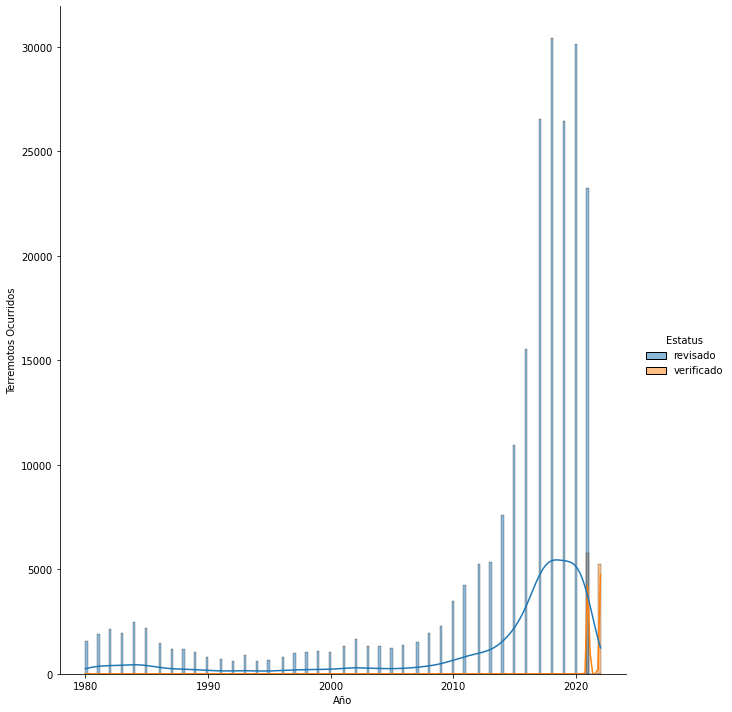

In [16]:
displot_sbn_df(df= df_terre, x='Año', hue='Estatus', y_name='Terremotos Ocurridos')

### Conteo de terremotos por Estados

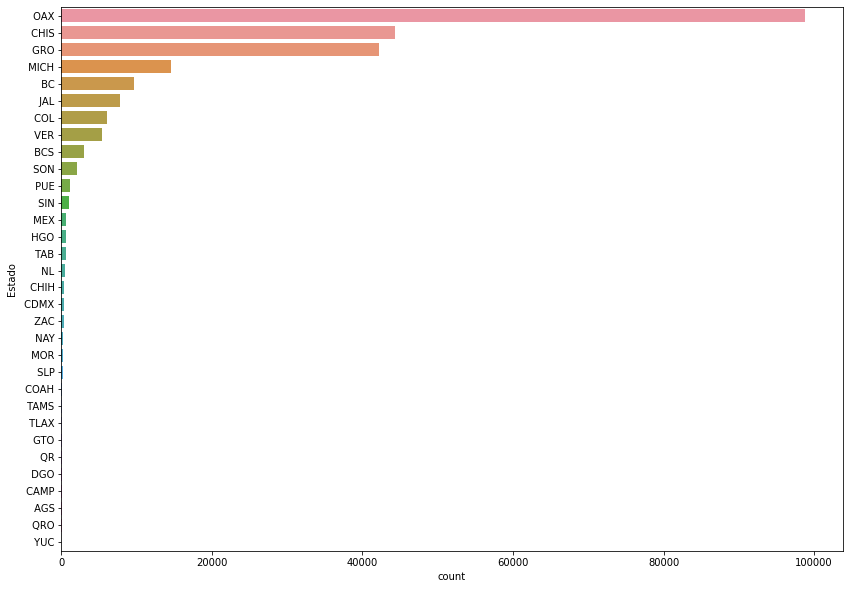

In [17]:
countplot_sbn_df(df_terre, y= 'Estado')

# Categarorizamos Variables

In [18]:
df_terre.dtypes

Magnitud                              object
Latitud                              float64
Longitud                             float64
Profundidad                           object
Referencia de localizacion            object
Estatus                               object
Fecha y Hora UTC              datetime64[ns]
Año                                    int64
Estado                                object
Municipio                             object
dtype: object

In [19]:
df_terre['Estado'] = pd.Categorical(
    df_terre['Estado'].apply(str)
)

df_terre['Año'] = pd.Categorical(
    df_terre['Año'].apply(int)
)

df_terre['Estatus'] = pd.Categorical(
    df_terre['Estatus'].apply(str)
)

In [20]:
df_terre.dtypes

Magnitud                              object
Latitud                              float64
Longitud                             float64
Profundidad                           object
Referencia de localizacion            object
Estatus                             category
Fecha y Hora UTC              datetime64[ns]
Año                                 category
Estado                              category
Municipio                             object
dtype: object

# Creamos un Subset

In [21]:
idx_filtro = df_terre['Estado'].isin([' NL', ' QR', ' CDMX'])

df_sample = df_terre[idx_filtro]

df_sample.sample(4)

,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Estatus,Fecha y Hora UTC,Año,Estado,Municipio
216743,3.6,24.8477,-99.4038,5.0,"17 km al ESTE de LINARES, NL",revisado,2021-05-23 00:56:57,2021,NL,LINARES
59083,4.3,16.1238,-88.7430,3.0,"267 km al SUR de CHETUMAL, QR",revisado,2014-01-14 03:06:54,2014,QR,CHETUMAL
11670,no calculable,19.3500,-99.3100,4.0,"3 km al NORESTE de SAN LORENZO ACOPILCO, CDMX",revisado,1985-10-16 19:40:35,1985,CDMX,SAN LORENZO ACOPILCO
86975,1.9,19.4465,-99.1848,5.0,"4 km al SUR de AZCAPOTZALCO, CDMX",revisado,2016-08-19 14:03:59,2016,CDMX,AZCAPOTZALCO


In [22]:
# df_sample = df_sample.set_index(['Estado', 'Año']).sort_index()
df_sample = df_sample.set_index(['Estado', 'Estatus', 'Año']).sort_index()

## Subset que ordenamos por categorias:
*   Estado
*   Estatus
*   Año

In [23]:
df_sample.head(10)

Magnitud  Latitud  Longitud Profundidad  \
Estado Estatus  Año                                                  
 CDMX  revisado 1980  no calculable    19.20    -99.10         5.0   
                1980  no calculable    19.40    -99.10         5.0   
                1980  no calculable    19.40    -99.20        11.0   
                1980  no calculable    19.20    -99.20         3.0   
                1980  no calculable    19.16    -99.24        37.0   
                1981            3.5    19.39    -99.20         2.0   
                1981  no calculable    19.37    -99.15         3.0   
                1981  no calculable    19.41    -99.19         4.0   
                1981  no calculable    19.24    -99.34         2.0   
                1981  no calculable    19.41    -99.13         5.0   

                                            Referencia de localizacion  \
Estado Estatus  Año                                                      
 CDMX  revisado 1980   2 km al NOROESTE de S SALVADOR CUAUHTENCO, CDMX   
                1980               1 km al NOROESTE de IZTACALCO, CDMX   
                1980  menos de 1 km al OESTE de V ALVARO OBREGON, CDMX   
                1980          2 km al SURESTE de S MIGUEL AJUSCO, CDMX   
                1980         7 km al SUROESTE de S MIGUEL AJUSCO, CDMX   
                1981             1 km al SUR de V ALVARO OBREGON, CDMX   
                1981                 3 km al NORESTE de COYOACAN, CDMX   
                1981  menos de 1 km al NORESTE de MIGUEL HIDALGO, CDMX   
                1981        10 km al SUR de SAN LORENZO ACOPILCO, CDMX   
                1981     2 km al SUROESTE de VENUSTIANO CARRANZA, CDMX   

                        Fecha y Hora UTC              Municipio  
Estado Estatus  Año                                              
 CDMX  revisado 1980 1980-03-31 16:39:42  S SALVADOR CUAUHTENCO  
                1980 1980-05-14 08:43:42              IZTACALCO  
                1980 1980-06-06 07:28:26       V ALVARO OBREGON  
                1980 1980-06-23 08:18:55        S MIGUEL AJUSCO  
                1980 1980-08-20 04:25:04        S MIGUEL AJUSCO  
                1981 1981-02-04 13:40:26       V ALVARO OBREGON  
                1981 1981-02-04 23:57:09               COYOACAN  
                1981 1981-02-05 23:58:36         MIGUEL HIDALGO  
                1981 1981-02-07 23:31:54   SAN LORENZO ACOPILCO  
                1981 1981-02-09 02:28:10    VENUSTIANO CARRANZA

In [24]:
ids = pd.IndexSlice

df_sample

Magnitud  Latitud  Longitud Profundidad  \
Estado Estatus  Año                                                  
 CDMX  revisado 1980  no calculable  19.2000  -99.1000         5.0   
                1980  no calculable  19.4000  -99.1000         5.0   
                1980  no calculable  19.4000  -99.2000        11.0   
                1980  no calculable  19.2000  -99.2000         3.0   
                1980  no calculable  19.1600  -99.2400        37.0   
...                             ...      ...       ...         ...   
 QR    revisado 2012            4.4  15.8322  -88.4172        10.0   
                2013            5.4  15.8648  -87.0532        10.0   
                2013            4.7  15.5658  -86.0355        10.0   
                2014            4.3  16.1238  -88.7430         3.0   
                2015            4.2  20.3183  -87.5048         5.0   

                                            Referencia de localizacion  \
Estado Estatus  Año                                                      
 CDMX  revisado 1980   2 km al NOROESTE de S SALVADOR CUAUHTENCO, CDMX   
                1980               1 km al NOROESTE de IZTACALCO, CDMX   
                1980  menos de 1 km al OESTE de V ALVARO OBREGON, CDMX   
                1980          2 km al SURESTE de S MIGUEL AJUSCO, CDMX   
                1980         7 km al SUROESTE de S MIGUEL AJUSCO, CDMX   
...                                                                ...   
 QR    revisado 2012                     296 km al SUR de CHETUMAL, QR   
                2013                 321 km al SURESTE de CHETUMAL, QR   
                2013                 405 km al SURESTE de CHETUMAL, QR   
                2014                     267 km al SUR de CHETUMAL, QR   
                2015         56 km al SUROESTE de PLAYA DEL CARMEN, QR   

                        Fecha y Hora UTC              Municipio  
Estado Estatus  Año                                              
 CDMX  revisado 1980 1980-03-31 16:39:42  S SALVADOR CUAUHTENCO  
                1980 1980-05-14 08:43:42              IZTACALCO  
                1980 1980-06-06 07:28:26       V ALVARO OBREGON  
                1980 1980-06-23 08:18:55        S MIGUEL AJUSCO  
                1980 1980-08-20 04:25:04        S MIGUEL AJUSCO  
...                                  ...                    ...  
 QR    revisado 2012 2012-05-11 06:14:58               CHETUMAL  
                2013 2013-04-10 19:13:59               CHETUMAL  
                2013 2013-08-24 18:58:47               CHETUMAL  
                2014 2014-01-14 03:06:54               CHETUMAL  
                2015 2015-01-12 03:49:16       PLAYA DEL CARMEN  

[823 rows x 7 columns]

# DataSet Estado

In [25]:
df_bak['Estado'].value_counts()

 OAX     98856
 CHIS    44377
 GRO     42165
 MICH    14506
 BC       9660
 JAL      7744
 COL      6071
 VER      5442
 BCS      3023
 SON      2095
 PUE      1191
 SIN      1034
 MEX       599
 HGO       572
 TAB       543
 NL        447
 CHIH      400
 CDMX      292
 ZAC       279
 NAY       264
 MOR       251
 SLP       198
 COAH      126
 TAMS      124
 TLAX      120
 GTO       103
 QR         84
 DGO        63
 CAMP       62
 AGS        45
 QRO        15
 YUC         3
Name: Estado, dtype: int64

In [26]:
df_Estado = crear_df_estado(estado='NL')

df_Estado.head()

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
12661,"54 km al SUROESTE de CD DE ALLENDE, NL",CD DE ALLENDE,NL,1986-02-26 22:49:56,1986,revisado,4.5,24.83,9.0
13128,"60 km al SUROESTE de LINARES, NL",LINARES,NL,1986-06-08 08:52:55,1986,revisado,3.7,24.50,9.0
18603,"6 km al SURESTE de HIDALGO, NL",HIDALGO,NL,1991-11-16 03:39:01,1991,revisado,no calculable,25.92,5.0
19044,"33 km al SUROESTE de LINARES, NL",LINARES,NL,1992-07-30 14:40:55,1992,revisado,4.3,24.70,10.0
26260,"45 km al SUROESTE de LINARES, NL",LINARES,NL,2000-09-20 06:24:59,2000,revisado,4.2,24.62,33.0


In [27]:
df_Estado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 12661 to 237205
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Referencia de localizacion  447 non-null    object        
 1   Municipio                   447 non-null    object        
 2   Estado                      447 non-null    object        
 3   Fecha y Hora UTC            447 non-null    datetime64[ns]
 4   Año                         447 non-null    int64         
 5   Estatus                     447 non-null    object        
 6   Magnitud                    447 non-null    object        
 7   Latitud                     447 non-null    float64       
 8   Profundidad                 447 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 34.9+ KB


In [28]:
df_Estado.shape

(447, 9)

# Seaborn Estado

### Distribucion por Años de Terremotos en el Estado Seleccionado

<Figure size 1008x720 with 0 Axes>

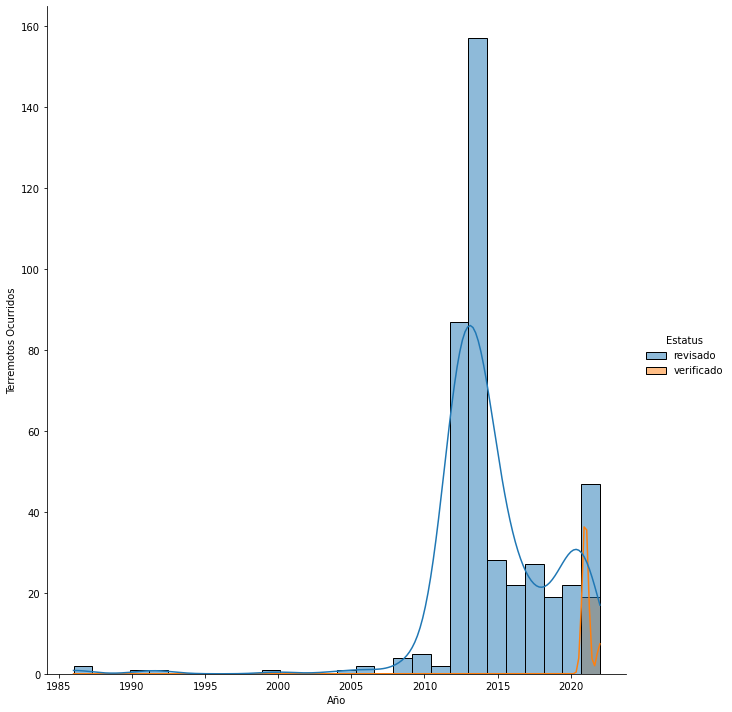

In [29]:
displot_sbn_df(df=df_Estado, x='Año', hue='Estatus', y_name='Terremotos Ocurridos')

### Conteo de Terremotos por Años en el Estado

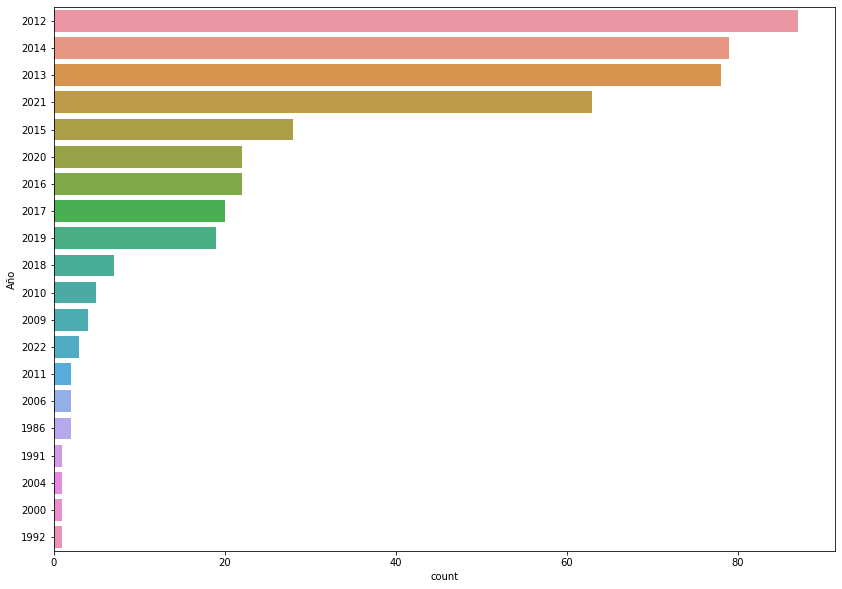

In [30]:
countplot_sbn_df(df=df_Estado, y='Año')

# Municipios del Estado

In [31]:
df_Estado['Municipio'].head()

12661    CD DE ALLENDE
13128          LINARES
18603          HIDALGO
19044          LINARES
26260          LINARES
Name: Municipio, dtype: object

In [32]:
df_Estado.sample(5)

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
51675,"56 km al NORESTE de LINARES, NL",LINARES,NL,2012-09-04 04:52:37,2012,revisado,3.6,25.1840,20.0
12661,"54 km al SUROESTE de CD DE ALLENDE, NL",CD DE ALLENDE,NL,1986-02-26 22:49:56,1986,revisado,4.5,24.8300,9.0
13128,"60 km al SUROESTE de LINARES, NL",LINARES,NL,1986-06-08 08:52:55,1986,revisado,3.7,24.5000,9.0
85631,"30 km al NORESTE de CIENEGA DE FLORES, NL",CIENEGA DE FLORES,NL,2016-07-21 17:37:45,2016,revisado,3.8,26.0340,4.8
58114,"22 km al NORTE de MONTEMORELOS, NL",MONTEMORELOS,NL,2013-11-18 19:39:20,2013,revisado,3.5,25.3857,5.0


### Conteo de Terremotos por Municipios en el Estado

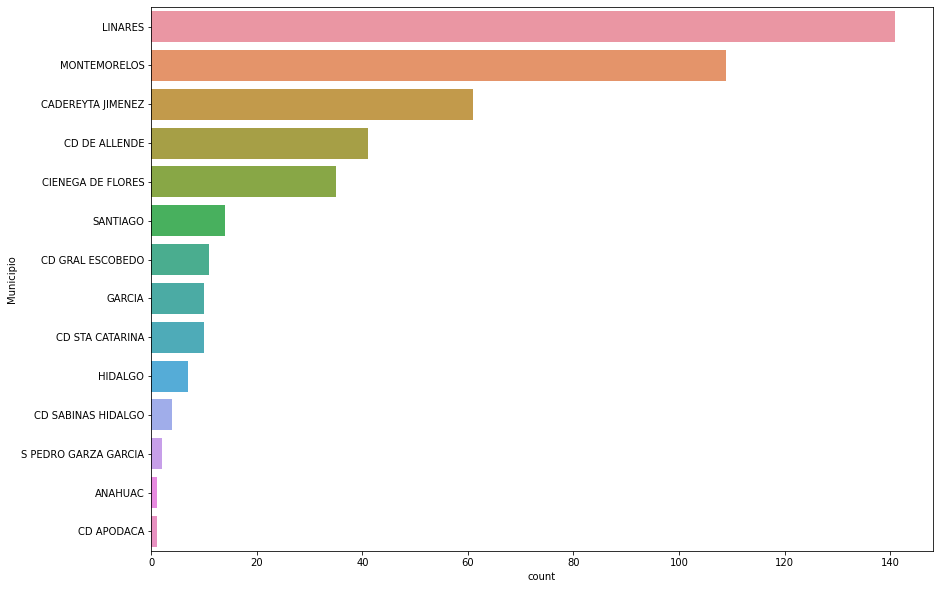

In [33]:
countplot_sbn_df(df= df_Estado, y= 'Municipio')

#Seaborn Magnitud de Terremoto

In [34]:
df_Estado['Magnitud_F'] = pd.to_numeric(
    df_Estado['Magnitud'],
    errors='coerce'
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
df_Estado.sample(5)

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad,Magnitud_F
58091,"45 km al ESTE de CADEREYTA JIMENEZ, NL",CADEREYTA JIMENEZ,NL,2013-11-17 15:04:12,2013,revisado,3.4,25.5758,20.0,3.4
53440,"53 km al NORESTE de LINARES, NL",LINARES,NL,2012-12-24 14:37:48,2012,revisado,3.6,25.1643,15.0,3.6
60773,"62 km al ESTE de CADEREYTA JIMENEZ, NL",CADEREYTA JIMENEZ,NL,2014-04-26 00:24:47,2014,revisado,3.4,25.6637,5.0,3.4
230591,"41 km al SUROESTE de CD DE ALLENDE, NL",CD DE ALLENDE,NL,2021-11-10 09:56:22,2021,verificado,4.0,25.0800,5.0,4.0
52455,"59 km al NORESTE de LINARES, NL",LINARES,NL,2012-10-29 06:47:39,2012,revisado,3.8,25.0670,5.0,3.8


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 48.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 24.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


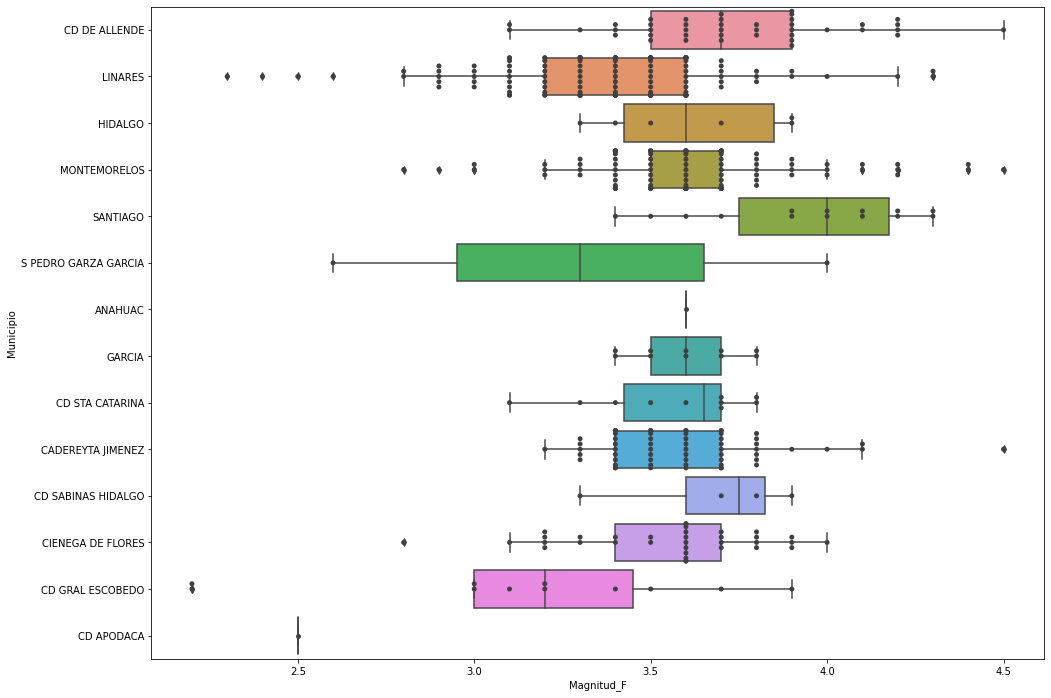

In [37]:
boxplot_swarmplot_sbn_df(df=df_Estado, x='Magnitud_F', y='Municipio')